## Frequency spectra

The most straightforward metric that can quantify the small scale structure in the data is the frequency spectra since the data is collected as a timeseries. 

The obvious issue with this metric is its interpretation, as the measurements are not perfectly Eulerian (at a single point). This implies that comparison to other measurments and theoretical estimates is hindered, but the measurement relative to other depths and other variables from the same data set are still useful. 


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as sg
import spectrum 
from scipy import stats, fft
import xarray as xr
from cmocean import cm as cmo

In [96]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [7]:
ds_660 = xr.open_dataset('data/sg_660_vert_4m_binned_geoff_cleaned_24_sept_2021.nc')
ds_659 = xr.open_dataset('data/sg_659_vert_4m_binned_geoff_cleaned_24_sept_2021.nc')

In [8]:
# Calculate a time axis as YTD
def datetime2ytd(time):
    """" Return time in YTD format from datetime format."""
    return  (time - np.datetime64('2019-01-01'))/np.timedelta64(1, 'D')
    
    
ds_659['days'] = datetime2ytd(ds_659.time)
ds_660['days'] = datetime2ytd(ds_660.time)

### Interpolate in time

In [10]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time(ds, var): 
    time_grid = np.arange(121, 205, 1/24)

   
    for i in range(len(ds.ctd_pressure)):
        ds_temp =ds.isel(ctd_pressure=i)
        f = interpolate.interp1d(ds_temp.days, ds_temp[var])
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "ctd_pressure": ds_temp.ctd_pressure}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int

In [11]:
ds_660_time = xr.merge([interp_time(ds_660,'sigma0'),
                        interp_time(ds_660,'CT'),
                        interp_time(ds_660,'SA')])

ds_659_time = xr.merge([interp_time(ds_659,'sigma0'),
                        interp_time(ds_659,'CT'),
                        interp_time(ds_659,'SA')])

### Multi-taper method

MTM is the best practical method for **estimating** the power spectral density (with limited data), as it gives the best balance between bias and variance. 

Here we use the implementation that is part of: https://pyspectrum.readthedocs.io/en/latest/ref_mtm.html

A nice understandable summary of the method (and comparison to periodogram and windowed estimate) is given in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5343535/ 
or http://jmlilly.net/course/v3/SpectralAnalysisDemo.html

There are two parameters that needs to be selected: 
- NW is the time-half-bandwidth. As described in the above reference this parameter sets the spectral resolution. Larger values would make sharp peaks broader, but also smooth over random spikes in the spectra that are not necessarily associated with periodicities. We will select this by trial and error. 
- k is the number of Slepian windows to be used. We will use the suggested optimal value of [2*NW] -1 .


(1e-06, 1)

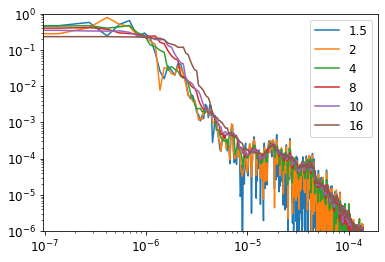

In [14]:
# First figure out what are a good set of parameters to use 
# Broad scale search
data = ds_660_time.sigma0.sel(ctd_pressure=600, method='nearest').values

for NW in [ 1.5, 2, 4, 8, 10, 16]:

    mtm_obj = spectrum.MultiTapering(data - np.mean(data), # remove mean
                                     NW=NW, 
                                     k = int(np.floor(2*NW)-1), 
                                     method='adapt',
                                     NFFT = len(data), 
                                     sampling=1/3600 # the sampling frequency (how large is 1/dt)
                                    )
    mtm_obj.run()
    plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-6, 1])
#plt.xlim([0, 1e-5])

(1e-06, 1)

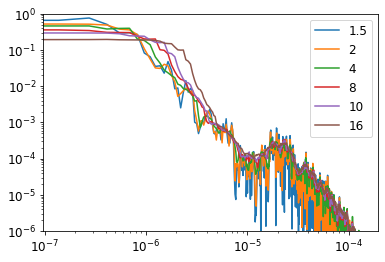

In [16]:
# First figure out what are a good set of parameters to use 
# Broad scale search
data = ds_659_time.sigma0.sel(ctd_pressure=600, method='nearest').values

for NW in [ 1.5, 2, 4, 8, 10, 16]:

    mtm_obj = spectrum.MultiTapering(data - np.mean(data), # remove mean
                                     NW=NW, 
                                     k = int(np.floor(2*NW)-1), 
                                     method='adapt',
                                     NFFT = len(data), 
                                     sampling=1/3600 # the sampling frequency (how large is 1/dt)
                                    )
    mtm_obj.run()
    plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-6, 1])
#plt.xlim([0, 1e-5])

(1e-06, 1)

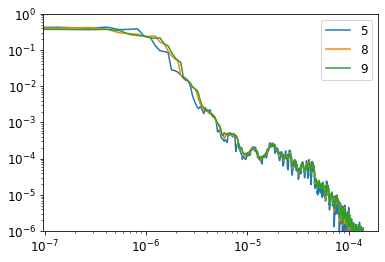

In [15]:
# fine grained
data = ds_660_time.sigma0.sel(ctd_pressure=600, method='nearest').values

for NW in [5,8, 9]:

    mtm_obj = spectrum.MultiTapering(data - np.mean(data),
                      NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                      NFFT = len(data), sampling=1/3600)
    mtm_obj.run()
    plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-6, 1])

(1e-06, 1)

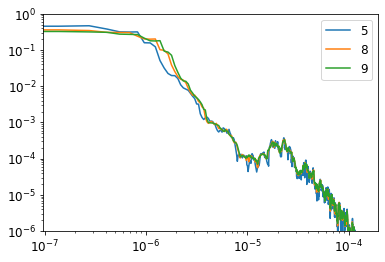

In [22]:
# fine grained
data = ds_659_time.sigma0.sel(ctd_pressure=600, method='nearest').values

for NW in [5,8, 9]:

    mtm_obj = spectrum.MultiTapering(data - np.mean(data),
                      NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                      NFFT = len(data), sampling=1/3600)
    mtm_obj.run()
    plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-6, 1])

Notice that at large values of NW the shoulder at the lower frequencies starts to extend further into the higher frequencies, artificially steepening the intermediate scale slope. This is to be expected as this parameters sets the width of the narrowband signals, and at values around 10 it would penetrate around a decade of scales.
While taking small values of NW gives a relatively rough spectrum, making it hard to pick out the faint signs of oscillations.  
We will pick a value of 9, as it seems like a reasonable balance, 

#### Apply to all depths in xarray way

In [41]:
def mtm_psd(ds, var, NW=10):
    #NW=10 # fix this based on testing done prior
    da = ds[var] - ds[var].mean('days') # remove a time mean 
    for i in range(len(da.ctd_pressure)): 
            
        data = da.isel(ctd_pressure=i)

        if len(data.where(np.isnan(data), drop=True))==0:
            
            mtm_obj = spectrum.MultiTapering(data.values,
                              NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                              NFFT = len(data), sampling=1/3600)
            mtm_obj.run()
            #plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW) 

            da_var_freq_temp = xr.DataArray(mtm_obj.psd, 
                                            dims=['freq'],
                                            coords={'freq': 24*3600*np.array(mtm_obj.frequencies()), # convert to per day
                                                    'ctd_pressure': data.ctd_pressure}).rename(var)

            if i==0:
                da_var_freq = da_var_freq_temp
            else:
                da_var_freq = xr.concat([da_var_freq, da_var_freq_temp], dim='ctd_pressure')
#        else:
            
    return da_var_freq

In [43]:
ds_660_freq = xr.merge([mtm_psd(ds_660_time, 'sigma0'),
                        mtm_psd(ds_660_time, 'CT'),
                        mtm_psd(ds_660_time, 'SA')])

In [44]:
ds_659_freq = xr.merge([mtm_psd(ds_659_time, 'sigma0'),
                        mtm_psd(ds_659_time, 'CT'),
                        mtm_psd(ds_659_time, 'SA')])

In [129]:
2.2*7.5

16.5

### Plotting

In [64]:
# take a simple average over the 2 data sets 
ds_mean_freq = 0.5*(ds_659_freq + ds_660_freq)

In [112]:
import matplotlib.colors as colors
from matplotlib import ticker

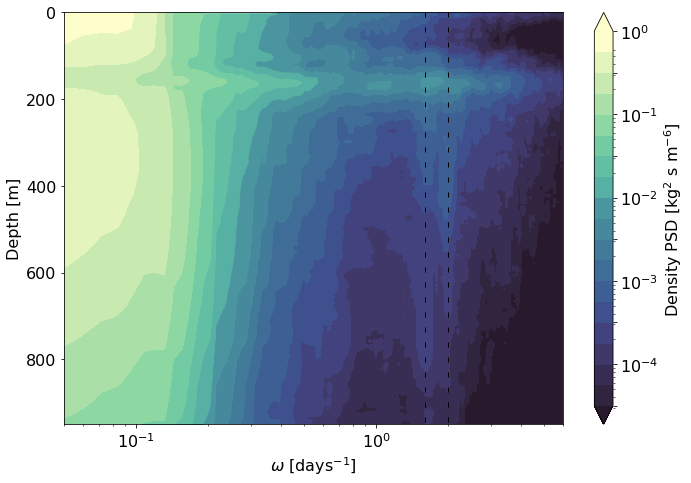

In [220]:
plt.figure(figsize=(10, 7))

lev_exp = np.linspace(-4.5,0, 19)
levs = np.power(10, lev_exp)
                    
cnt = ds_mean_freq.sigma0.plot.contourf(levels=levs,
                                   norm=colors.LogNorm(vmin=3e-5),
                                   cmap=cmo.deep_r, extend='both',
                                   cbar_kwargs={'label':'Density PSD [kg$^2$ s m$^{-6}$]'})

for c in cnt.collections:
    c.set_edgecolor("face")
    
plt.vlines([24/15, 24/12], 0, 1e3, linestyles=(0, (5, 10)), linewidth=1, colors='k')

#plt.vlines([24/15, 24/12], 0, 1e3, linestyles='--', linewidth=1, colors='k')

plt.xscale('log')
plt.xlim([1/20, 24/4])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('$\omega$ [days$^{-1}$]')
plt.title('')
plt.tight_layout()
#plt.savefig('figures/figure_rho_spec_panel1.pdf')

In [135]:
### Fit line and estimate slopes as a function of frequency

In [137]:
ds_mean_freq

<xarray.Dataset>
Dimensions:       (ctd_pressure: 244, freq: 1009)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 966.0 970.0 974.0
  * freq          (freq) float64 0.0 0.0119 0.02381 0.03571 ... 11.98 11.99 12.0
Data variables:
    sigma0        (ctd_pressure, freq) float64 0.6313 0.6324 ... 1.014e-07
    CT            (ctd_pressure, freq) float64 42.42 42.46 ... 2.251e-06
    SA            (ctd_pressure, freq) float64 0.1244 0.1252 ... 1.956e-07

In [194]:
npres = len(ds_mean_freq.ctd_pressure)
m = np.zeros((npres,))
m_659 = np.zeros((npres,))
m_660 = np.zeros((npres,))

for i in range(npres):
    ds_temp  = ds_mean_freq.sigma0.isel(ctd_pressure=i).sel(freq=slice(1/10, 24/18))
    x = ds_temp.freq.values
    y = ds_temp.values
    m[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_659_freq.sigma0.isel(ctd_pressure=i).sel(freq=slice(1/10, 24/18))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_659[i],b = np.polyfit(np.log(x), np.log(y),1)    

    ds_temp  = ds_660_freq.sigma0.isel(ctd_pressure=i).sel(freq=slice(1/10, 24/18))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_660[i],b = np.polyfit(np.log(x), np.log(y),1)    

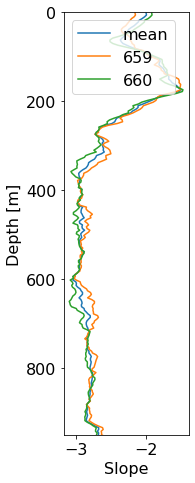

In [196]:
plt.figure(figsize=(3,7))

plt.plot(m, ds_mean_freq.ctd_pressure, label='mean')

plt.plot(m_659, ds_mean_freq.ctd_pressure, label='659')
plt.plot(m_660, ds_mean_freq.ctd_pressure, label='660')

plt.gca().invert_yaxis()

plt.legend()
plt.xlabel('Slope')
plt.ylabel('Depth [m]')
plt.ylim([950, 0])
plt.tight_layout()

#plt.savefig('figures/figure_rho_spec_panel2.pdf')


### Wavenumber spectra for straightish section 

In [170]:
# select straight section
ds_660_scX = ds_660.sel(dives=slice(225, 337))#.sel(ctd_pressure=500, method='nearest')
ds_659_scX = ds_659.sel(dives=slice(182, 287))#.sel(ctd_pressure=500, method='nearest')


In [173]:
import glidertools as gt


In [171]:
def interp_distance(ds, var): 
    #dist_grid = np.arange(20e3, 475e3, 500)
    dist_grid = np.arange(0, 416e3, 500)
    
    for i in range(len(ds.ctd_pressure)): 
        ds_temp = ds.isel(ctd_pressure=i)
      
        distance = np.cumsum(gt.utils.distance(ds_temp.longitude, ds_temp.latitude)) 
        data = ds_temp[var].values
        f = interpolate.interp1d(distance, data)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, "ctd_pressure": ds_temp.ctd_pressure}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int
            

In [174]:
ds_660_dist_sec = xr.merge( [interp_distance(ds_660_scX, 'sigma0')] )
ds_659_dist_sec = xr.merge( [interp_distance(ds_659_scX, 'sigma0')] )

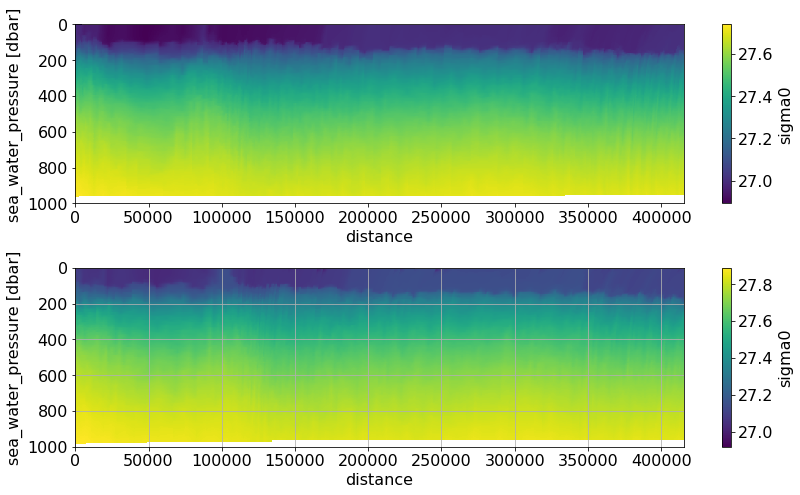

In [175]:
plt.figure(figsize=(12, 7))
plt.subplot(211)
ds_659_dist_sec.sigma0.plot()
plt.gca().invert_yaxis()

plt.subplot(212)
ds_660_dist_sec.sigma0.plot()
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()


In [176]:
def mtm_psd(ds, var):
    NW=4 # fix this based on testing done prior
    da = ds[var] - ds[var].mean('distance') # remove a distance mean 
    n=0
    for i in range(len(da.ctd_pressure)): 

        data = da.isel(ctd_pressure=i)
        
        if len(data.where(np.isnan(data), drop=True))==0: 
        
            mtm_obj = spectrum.MultiTapering(data.values,
                              NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                              NFFT = len(data.values), sampling=1/500)
            mtm_obj.run()
            #plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW) 

            da_var_freq_temp = xr.DataArray(mtm_obj.psd, 
                                            dims=['k'],
                                            coords={'k': np.array(mtm_obj.frequencies()), # convert to per day
                                                    'ctd_pressure': data.ctd_pressure}).rename(var)

            if n==0:
                da_var_freq = da_var_freq_temp
                n=n+1
            else:
                da_var_freq = xr.concat([da_var_freq, da_var_freq_temp], dim='ctd_pressure')
    
    return da_var_freq

In [177]:
ds_659_wnum = xr.merge([mtm_psd(ds_659_dist_sec, 'sigma0')] )
ds_660_wnum = xr.merge([mtm_psd(ds_660_dist_sec, 'sigma0')] )

In [178]:
ds_mean_wnum = 0.5*(ds_659_wnum + ds_660_wnum)

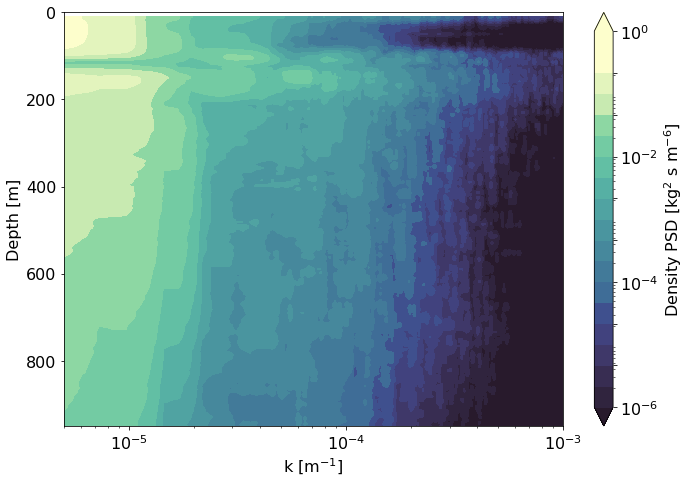

In [192]:
plt.figure(figsize=(10, 7))

lev_exp = np.linspace(-6,0, 19)
levs = np.power(10, lev_exp)
                    
cnt = ds_mean_wnum.sigma0.plot.contourf(levels=levs,
                                   norm=colors.LogNorm(vmin=1e-6),
                                   cmap=cmo.deep_r, extend='both',
                                   cbar_kwargs={'label':'Density PSD [kg$^2$ s m$^{-6}$]'})

for c in cnt.collections:
    c.set_edgecolor("face")
    
#plt.vlines([24/15, 24/12], 0, 1e3, linestyles=(0, (5, 10)), linewidth=1, colors='k')

#plt.vlines([24/15, 24/12], 0, 1e3, linestyles='--', linewidth=1, colors='k')

plt.xscale('log')
plt.xlim([1/200e3, 1/1e3])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('k [m$^{-1}$]')
plt.title('')
plt.tight_layout()
plt.savefig('figures/figure_rho_wnum_spec_panel1.pdf')

In [190]:
npres = len(ds_mean_wnum.ctd_pressure)
m_mean = np.zeros((npres,))
m_659 = np.zeros((npres,))
m_660 = np.zeros((npres,))

for i in range(npres):
    ds_temp  = ds_mean_wnum.sigma0.isel(ctd_pressure=i).sel(k=slice(1/100e3, 1/5e3))
    x = ds_temp.k.values
    y = ds_temp.values
    m_mean[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_659_wnum.sigma0.isel(ctd_pressure=i).sel(k=slice(1/100e3, 1/5e3))
    x = ds_temp.k.values
    y = ds_temp.values
    m_659[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_660_wnum.sigma0.isel(ctd_pressure=i).sel(k=slice(1/100e3, 1/5e3))
    x = ds_temp.k.values
    y = ds_temp.values
    m_660[i],b = np.polyfit(np.log(x), np.log(y),1)

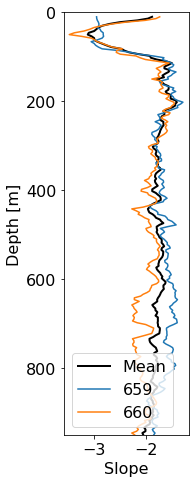

In [193]:
plt.figure(figsize=(3,7))

plt.plot(m_mean, ds_mean_wnum.ctd_pressure, color='k', linewidth=2, label='Mean')
plt.plot(m_659, ds_mean_wnum.ctd_pressure, label='659' )
plt.plot(m_660, ds_mean_wnum.ctd_pressure, label='660')
plt.gca().invert_yaxis()

#plt.vlines([-2, -5/3, -1], 27.1, 27.7, linestyles='--')
plt.legend()
#plt.xlim([-2.2, -1.2])
plt.xlabel('Slope')
plt.ylabel('Depth [m]')
plt.ylim([950, 0])
#plt.ylim([27.65, 27.15])
plt.tight_layout()

#plt.savefig('figures/figure_iso_spec_sec_wnum_panel2.pdf')
plt.savefig('figures/figure_rho_wnum_spec_panel2.pdf')


### Frequency spectra for straightish section

We want to check if the slope of -3 that is seen in the frequency spectra over the full domain holds even for smaller section.

This analysis shows that the frequency spectra slope is not too different if using the full vs part of the glider time series, and has a slope around -2.5 to -3. 

In [203]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time_section(ds, var): 
    time_grid = np.arange(149, 168.5, 1/24)

   
    for i in range(len(ds.ctd_pressure)):
        ds_temp =ds.isel(ctd_pressure=i)
        f = interpolate.interp1d(ds_temp.days, ds_temp[var], bounds_error=False)
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "ctd_pressure": ds_temp.ctd_pressure}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int

In [204]:
ds_660_time_sec = xr.merge( [interp_time_section(ds_660_scX, 'sigma0')] )
ds_659_time_sec = xr.merge( [interp_time_section(ds_659_scX, 'sigma0')] )

In [205]:
def mtm_psd_sec(ds, var, NW=4):
    #NW=10 # fix this based on testing done prior
    da = ds[var] - ds[var].mean('days') # remove a time mean 
    for i in range(len(da.ctd_pressure)): 
            
        data = da.isel(ctd_pressure=i)

        if len(data.where(np.isnan(data), drop=True))==0:
            
            mtm_obj = spectrum.MultiTapering(data.values,
                              NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                              NFFT = len(data), sampling=1/3600)
            mtm_obj.run()
            #plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW) 

            da_var_freq_temp = xr.DataArray(mtm_obj.psd, 
                                            dims=['freq'],
                                            coords={'freq': 24*3600*np.array(mtm_obj.frequencies()), # convert to per day
                                                    'ctd_pressure': data.ctd_pressure}).rename(var)

            if i==0:
                da_var_freq = da_var_freq_temp
            else:
                da_var_freq = xr.concat([da_var_freq, da_var_freq_temp], dim='ctd_pressure')
#        else:
            
    return da_var_freq

In [207]:
ds_660_freq_sec = xr.merge([mtm_psd_sec(ds_660_time_sec, 'sigma0')])
ds_659_freq_sec = xr.merge([mtm_psd_sec(ds_659_time_sec, 'sigma0')])

In [208]:
ds_mean_freq_sec = 0.5*(ds_659_freq_sec + ds_660_freq_sec)

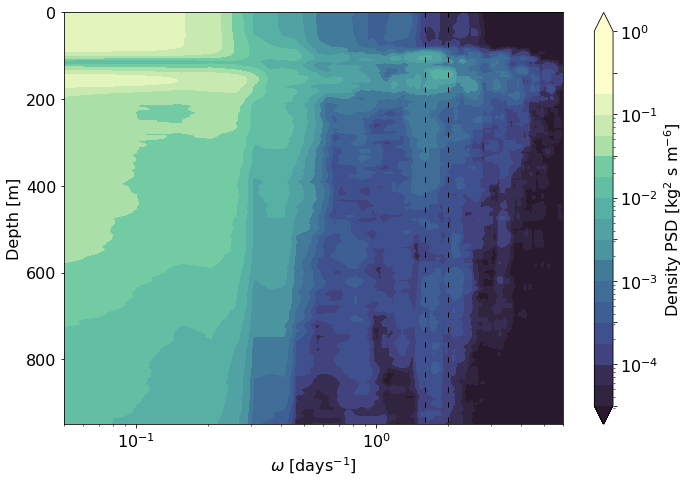

In [217]:
plt.figure(figsize=(10, 7))

lev_exp = np.linspace(-4.5,0, 19)
levs = np.power(10, lev_exp)
                    
cnt = ds_659_freq_sec.sigma0.plot.contourf(levels=levs,
                                   norm=colors.LogNorm(vmin=3e-5),
                                   cmap=cmo.deep_r, extend='both',
                                   cbar_kwargs={'label':'Density PSD [kg$^2$ s m$^{-6}$]'})

for c in cnt.collections:
    c.set_edgecolor("face")
    
plt.vlines([24/15, 24/12], 0, 1e3, linestyles=(0, (5, 10)), linewidth=1, colors='k')

#plt.vlines([24/15, 24/12], 0, 1e3, linestyles='--', linewidth=1, colors='k')

plt.xscale('log')
plt.xlim([1/20, 24/4])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('$\omega$ [days$^{-1}$]')
plt.title('')
plt.tight_layout()
#plt.savefig('figures/figure_rho_spec_panel1.pdf')

In [214]:
npres = len(ds_mean_freq_sec.ctd_pressure)
m = np.zeros((npres,))
m_659 = np.zeros((npres,))
m_660 = np.zeros((npres,))

for i in range(npres):
    ds_temp  = ds_mean_freq_sec.sigma0.isel(ctd_pressure=i).sel(freq=slice(1/5, 24/18))
    x = ds_temp.freq.values
    y = ds_temp.values
    m[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_659_freq_sec.sigma0.isel(ctd_pressure=i).sel(freq=slice(1/5, 24/18))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_659[i],b = np.polyfit(np.log(x), np.log(y),1)    

    ds_temp  = ds_660_freq_sec.sigma0.isel(ctd_pressure=i).sel(freq=slice(1/5, 24/18))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_660[i],b = np.polyfit(np.log(x), np.log(y),1)    

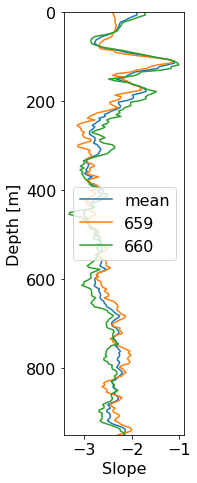

In [215]:
plt.figure(figsize=(3,7))

plt.plot(m, ds_mean_freq_sec.ctd_pressure, label='mean')

plt.plot(m_659, ds_mean_freq_sec.ctd_pressure, label='659')
plt.plot(m_660, ds_mean_freq_sec.ctd_pressure, label='660')

plt.gca().invert_yaxis()

plt.legend()
plt.xlabel('Slope')
plt.ylabel('Depth [m]')
plt.ylim([950, 0])
plt.tight_layout()

#plt.savefig('figures/figure_rho_spec_panel2.pdf')


### Scraps

Text(0.5, 1.0, '')

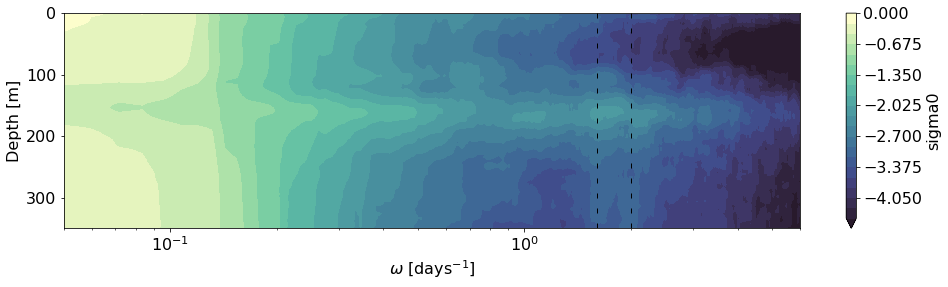

In [97]:
plt.figure(figsize=(13,2.2*1.8))

np.log10(ds_mean_freq.sigma0).plot.contourf(levels=np.linspace(-4.5, 0, 21), cmap=cmo.deep_r)

plt.vlines([24/15, 24/12], 0, 1e3, linestyles=(0, (5, 10)), linewidth=1, colors='k')

#plt.vlines([24/15, 24/12], 0, 1e3, linestyles='--', linewidth=1, colors='k')

plt.xscale('log')
plt.xlim([1/20, 24/4])
plt.ylim([0, 350])
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('$\omega$ [days$^{-1}$]')
plt.title('')


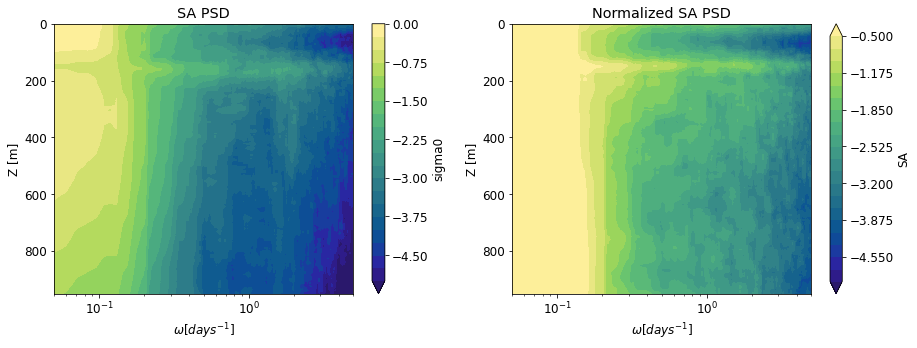

In [60]:
plt.figure(figsize=(13,5))
plt.subplot(121)
np.log10(ds_660_freq.sigma0).plot.contourf(levels=np.linspace(-5, 0, 21), cmap=cmo.haline)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('SA PSD')

plt.subplot(122)
np.log10((ds_660_freq.SA / ds_660_freq.SA.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21), cmap=cmo.haline)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized SA PSD')

plt.tight_layout()
#plt.savefig('figures/SA_depth_spec.pdf')

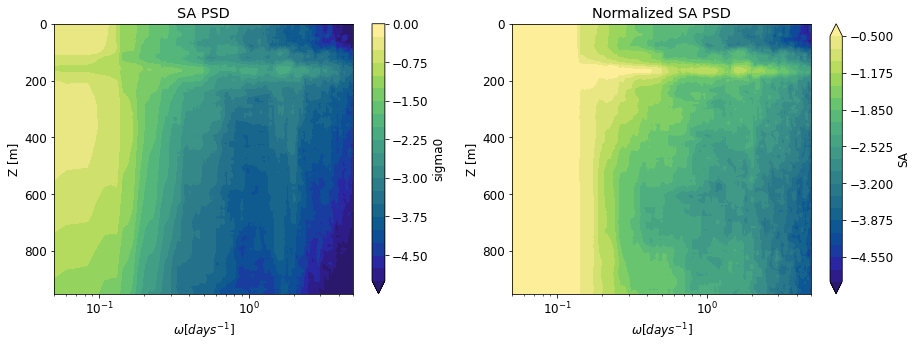

In [61]:
plt.figure(figsize=(13,5))
plt.subplot(121)
np.log10(ds_659_freq.sigma0).plot.contourf(levels=np.linspace(-5, 0, 21), cmap=cmo.haline)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('SA PSD')

plt.subplot(122)
np.log10((ds_659_freq.SA / ds_659_freq.SA.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21), cmap=cmo.haline)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized SA PSD')

plt.tight_layout()
#plt.savefig('figures/SA_depth_spec.pdf')

Text(0.5, 1.0, 'SA PSD')

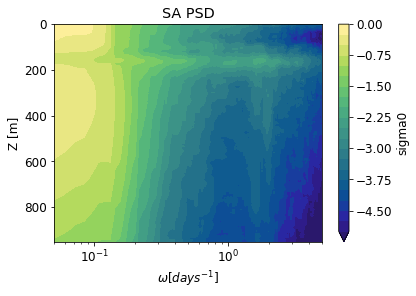

In [62]:
np.log10(ds_mean_freq.sigma0).plot.contourf(levels=np.linspace(-5, 0, 21), cmap=cmo.haline)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('SA PSD')


Text(0.5, 1.0, 'SA PSD')

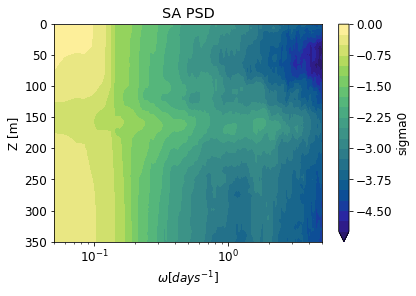

In [63]:
np.log10(ds_mean_freq.sigma0).plot.contourf(levels=np.linspace(-5, 0, 21), cmap=cmo.haline)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 350])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('SA PSD')


(0.05, 8.0)

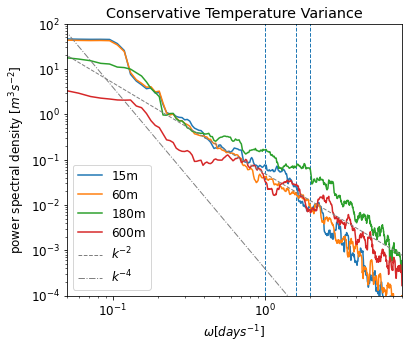

In [47]:
plt.figure(figsize=(6,5))

for i in [15, 60, 180, 600]:
        ds_660_freq.CT.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = ds_660_freq.freq
plt.plot(freq, 5e-2*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 4e-4*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='lower left')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Conservative Temperature Variance')

plt.ylim([1e-4, 1e2])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])
#plt.savefig('figures/CT_line_spec.pdf')

(0.05, 8.0)

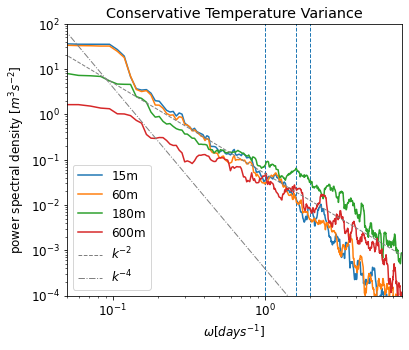

In [48]:
plt.figure(figsize=(6,5))

for i in [15, 60, 180, 600]:
        ds_659_freq.CT.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = ds_660_freq.freq
plt.plot(freq, 5e-2*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 4e-4*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='lower left')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Conservative Temperature Variance')

plt.ylim([1e-4, 1e2])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])
#plt.savefig('figures/CT_line_spec.pdf')

#### Potential Energy

*We finally decided to consider density variance instead of PE, because PE is not clearly defined  when N2 varies rapidly or has a peak, as at the base of the ML.*

We consider potential energy instead of simply buoyancy spectrum as it is a dynamically more meaningful option. 


Some details of the theory (Vallis book, Chapter 2): 

Density ($\rho$) can be written in a separable form as: 
\begin{align}
\rho & =  \rho_0 + \delta \rho (x,y,z,t) \\ & = \rho_0 + \hat{\rho} (z) + \rho'(x,y,z,t) \\ & = \tilde{\rho} (z) + \rho'(x,y,z,t)
\end{align}
where $|\delta \rho|, |\hat{\rho}|, |\rho'| << \rho_0$

Buoyancy is defined as 
\begin{align}
b & = -g \delta \rho / \rho_0  \\ & = -g ( \hat{\rho} (z) / \rho_0 + \rho' (x,y,z,t) /\rho_0 
\\ & = \tilde{b}(z) + b' [m/s^2]
\end{align}

and $N^2 = d \tilde{b}/ dz [1/s^2]$. 
So PE can be defined as $\frac{1}{2} \frac{<b'^2>}{ N^2} [m^2/s^2]$.


In [45]:
# Practically define tilde as the average
rho_tilde = ds_660_time.sigma0.mean('days')
rho_prime = ds_660_time.sigma0 - rho_tilde

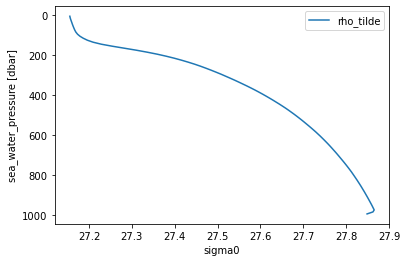

In [479]:
rho_tilde.plot(y='ctd_pressure', label='rho_tilde')
plt.gca().invert_yaxis()
plt.legend()

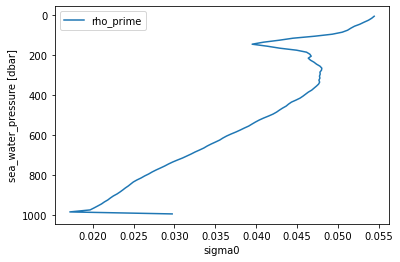

In [430]:
np.abs(rho_prime).mean('days').plot(y='ctd_pressure', label='rho_prime')
plt.gca().invert_yaxis()
plt.legend()

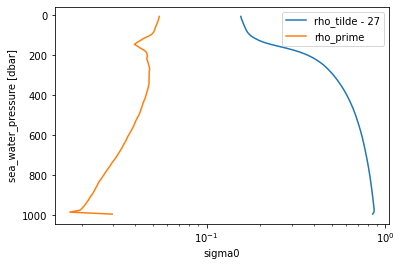

In [431]:
# Here we see that rho' is really much smaller than rho_tilde.
(rho_tilde-27).plot(y='ctd_pressure', label='rho_tilde - 27') # Subtract 27 just to show that rho_0 can vary
np.abs(rho_prime).mean('days').plot(y='ctd_pressure', label='rho_prime')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.legend()

In [480]:
g = 9.81
rho_0 = 1000
b_tilde = - (g*rho_tilde/rho_0).rename('b_tilde')
b_prime = - (g*rho_prime/rho_0).rename('b_prime')

In [481]:
N2 = (b_tilde.diff('ctd_pressure') / (-b_tilde.ctd_pressure).diff('ctd_pressure')).rename('N2')
# need '-' as the Z should be increasing towards the surface

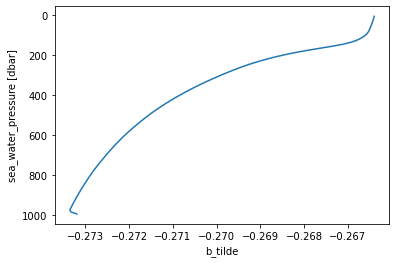

In [482]:
b_tilde.plot(y='ctd_pressure')
plt.gca().invert_yaxis()

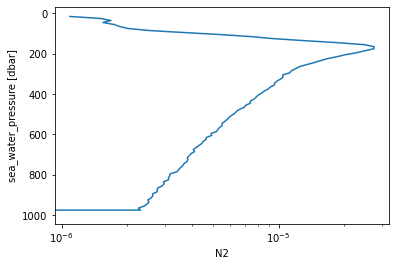

In [483]:
N2.plot(y='ctd_pressure')
plt.gca().invert_yaxis()
plt.xscale('log')

In [484]:
PE_spec = 0.5*(g**2)*ds_660_freq.sigma0/N2 # the spectrum of buoyancy

In [485]:
PE_spec

<xarray.DataArray (ctd_pressure: 99, freq: 1021)>
array([[ 3.29795366e+07,  3.29279847e+07,  3.18139624e+07, ...,
         5.43774016e+02,  5.35199686e+02,  5.45674879e+02],
       [ 2.37301988e+07,  2.37058205e+07,  2.29001225e+07, ...,
         1.39738374e+02,  1.43789984e+02,  1.42351132e+02],
       [ 2.11061100e+07,  2.10671984e+07,  2.03232528e+07, ...,
         7.07239431e+01,  7.28752064e+01,  7.61148980e+01],
       ...,
       [ 2.25419464e+06,  2.23808787e+06,  2.12488041e+06, ...,
         2.66872397e+00,  2.38996984e+00,  2.25837027e+00],
       [-1.40320310e+06, -1.39223126e+06, -1.32401016e+06, ...,
        -1.82223942e+00, -1.78868829e+00, -1.77315543e+00],
       [-1.92595668e+06, -1.92230424e+06, -1.85758215e+06, ...,
        -8.07848192e-03, -9.04367807e-03, -7.97376470e-03]])
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 15.0 25.0 35.0 ... 975.0 985.0 995.0
  * freq          (freq) float64 0.0 0.01176 0.02353 ... 11.98 11.99 12.0

#### Line plots

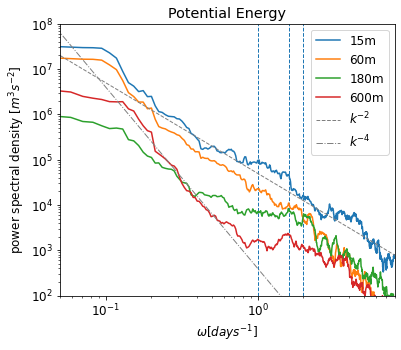

In [551]:
plt.figure(figsize=(6,5))
for i in [15, 60, 180, 600]:
        PE_spec.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = PE_spec.freq
plt.plot(freq, 5e4*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 4e2*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='upper right')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e2, 1e8, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Potential Energy')

plt.ylim([1e2, 1e8])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])

plt.savefig('figures/PE_line_spec.pdf')

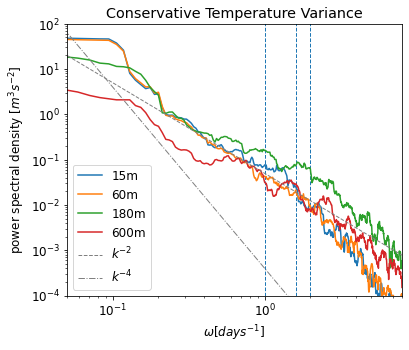

In [552]:
plt.figure(figsize=(6,5))

for i in [15, 60, 180, 600]:
        ds_660_freq.CT.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = PE_spec.freq
plt.plot(freq, 5e-2*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 4e-4*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='lower left')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Conservative Temperature Variance')

plt.ylim([1e-4, 1e2])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])
plt.savefig('figures/CT_line_spec.pdf')

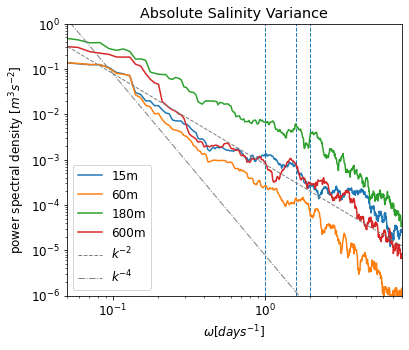

In [553]:
plt.figure(figsize=(6,5))

for i in [15, 60, 180, 600]:
        ds_660_freq.SA.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = PE_spec.freq
plt.plot(freq, 8e-4*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 8e-6*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='lower left')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e-6, 1e5, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Absolute Salinity Variance')

plt.ylim([1e-6, 1e0])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])
plt.savefig('figures/SA_line_spec.pdf')

#### Depth-Frequency plots

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/plot/plot.py:991: UserWarning: The following kwargs were not used by contour: 'rasterize'
  primitive = ax.contourf(x, y, z, **kwargs)


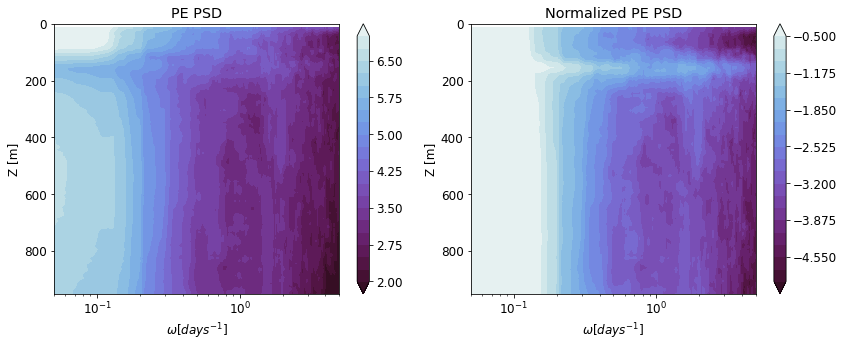

In [559]:
plt.figure(figsize=(12,5))
plt.subplot(121)
np.log10(PE_spec).plot.contourf(levels=np.linspace(2, 7, 21), cmap=cmo.dense_r)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('PE PSD')

plt.subplot(122)
np.log10((PE_spec / PE_spec.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21), cmap=cmo.dense_r)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized PE PSD')

plt.tight_layout()
plt.savefig('figures/PE_depth_spec.pdf')

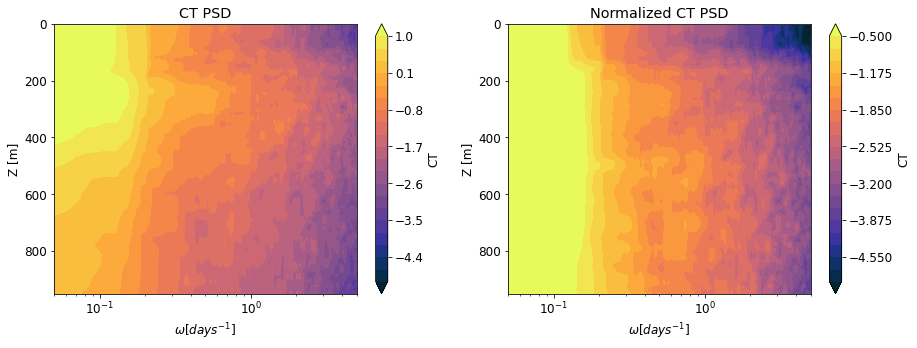

In [555]:
plt.figure(figsize=(13,5))
plt.subplot(121)
np.log10(ds_660_freq.CT).plot.contourf(levels=np.linspace(-5, 1, 21), cmap=cmo.thermal)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('CT PSD')

plt.subplot(122)
np.log10((ds_660_freq.CT / ds_660_freq.CT.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21) , cmap=cmo.thermal)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized CT PSD')

plt.tight_layout()
plt.savefig('figures/CT_depth_spec.pdf')

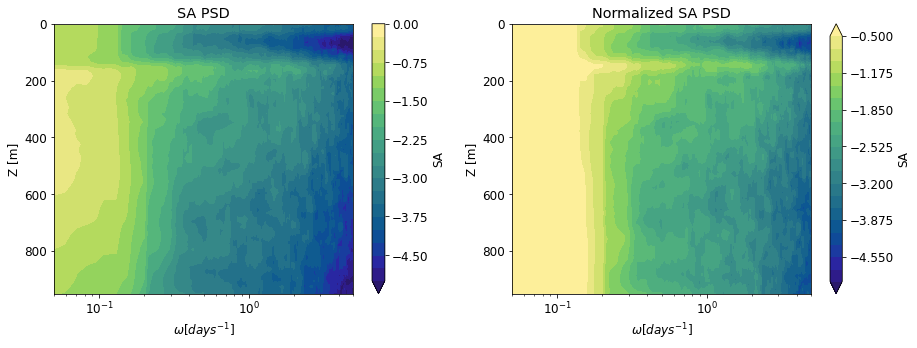

In [556]:
plt.figure(figsize=(13,5))
plt.subplot(121)
np.log10(ds_660_freq.SA).plot.contourf(levels=np.linspace(-5, 0, 21), cmap=cmo.haline)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('SA PSD')

plt.subplot(122)
np.log10((ds_660_freq.SA / ds_660_freq.SA.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21), cmap=cmo.haline)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized SA PSD')

plt.tight_layout()
plt.savefig('figures/SA_depth_spec.pdf')